In [1]:

# Set up notebook
%pprint
%matplotlib inline
import sys
import os.path as osp, os as os

executable_path = sys.executable
scripts_folder = osp.join(osp.dirname(executable_path), 'Scripts'); assert osp.exists(scripts_folder)
py_folder = osp.abspath(osp.join(os.pardir, 'py')); assert osp.exists(py_folder), "Create the py folder"
ffmpeg_folder = r'C:\ffmpeg\bin'; assert osp.exists(ffmpeg_folder)
shared_folder = osp.abspath(osp.join(os.pardir, 'share')); assert osp.exists(shared_folder)
scripts312_folder = r'C:\Users\daveb\AppData\Roaming\Python\Python312\Scripts'; assert osp.exists(scripts312_folder)

if (scripts_folder not in sys.path): sys.path.insert(1, scripts_folder)
if (py_folder not in sys.path): sys.path.insert(1, py_folder)
if (ffmpeg_folder not in sys.path): sys.path.insert(1, ffmpeg_folder)
if shared_folder not in sys.path: sys.path.insert(1, shared_folder)
if (scripts312_folder not in sys.path): sys.path.insert(1, scripts312_folder)

from notebook_utils import NotebookUtilities
nu = NotebookUtilities(
    data_folder_path=osp.abspath(osp.join(os.pardir, 'data')),
    saves_folder_path=osp.abspath(osp.join(os.pardir, 'saves'))
)
nu.delete_ipynb_checkpoint_folders()

Pretty printing has been turned OFF


In [2]:

# Get a hand-valued dictionary of font sizes for each country
fontsize_dict = {
    'Iran': 140,
    'Turkey': 82,
    'Iraq': 76,
    'Egypt': 60,
    'Yemen': 50,
    'Saudi Arabia': 46,
    'Oman': 36,
    'Syria': 36,
    'Jordan': 18,
    'Israel': 8,
    'Kuwait': 8,
    'United Arab Emirates': 6,
    'Lebanon': 5,
    'Qatar': 4,
    'Bahrain': 1,
}


## Get some good country colors

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:51<00:00, 10.28s/it]


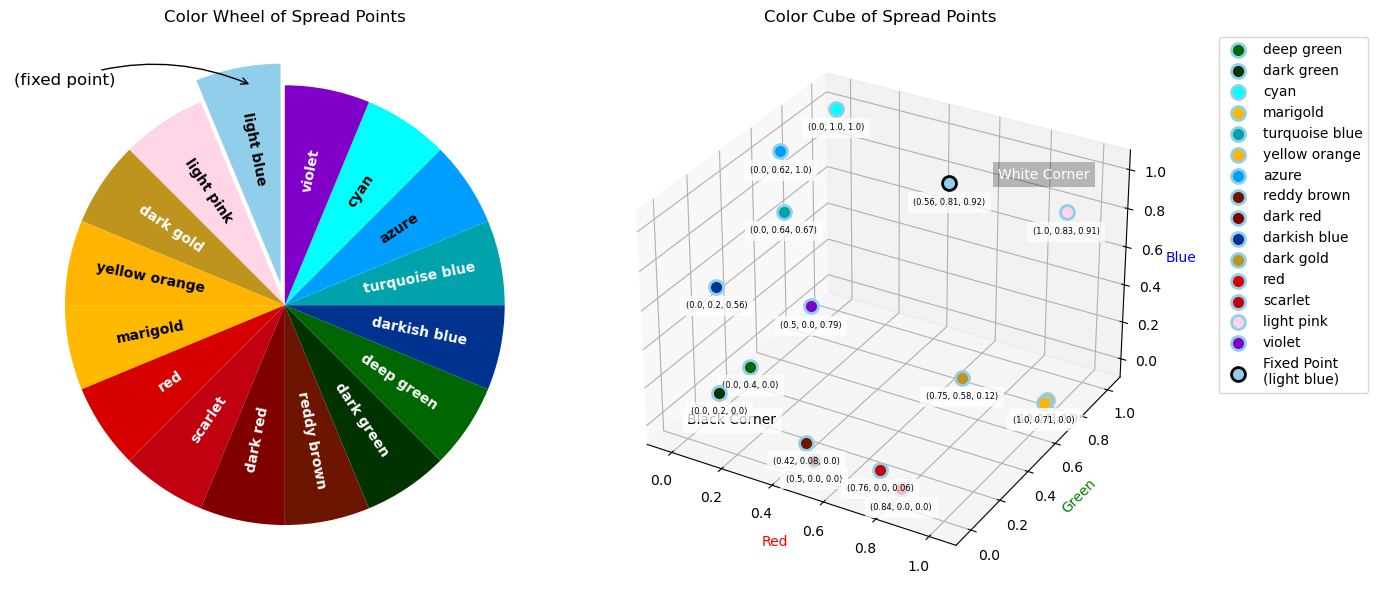

In [3]:

from tqdm import tqdm
from colormath.color_objects import LabColor

# Get a fixed point in the CIELAB color space
ranges = [(0, 100), (-128, 127), (-128, 127)]
ocean_color = (0.5294117647058824, 0.807843137254902, 0.9215686274509803)  # light blue
fixed_point = nu.rgb_to_lab(ocean_color).get_value_tuple()

# Get additional points to spread
point_count = len(fontsize_dict)

# Initialize a list to store trial results
trials = []
total_trials = 5  # Adjust this based on your patience

# Perform trials to find the best spread of points
with tqdm(total=total_trials) as pbar:
    while len(trials) < total_trials:
        
        # Attempt to spread the points evenly within the color space
        try:
            spread_points = nu.spread_points_in_cube(
                point_count, fixed_point, *ranges, verbose=False
            )

            # Ensure spread points have all unique XKCD names
            xkcd_set = set()
            for lab_color in spread_points:
                rgb_color = nu.lab_to_rgb(LabColor(*lab_color))
                nearest_neighbor = nu.get_nearest_neighbor(rgb_color, nu.xkcd_colors)
                xkcd_set.add(nu.nearest_xkcd_name_dict[nearest_neighbor])
            if len(xkcd_set) == len(spread_points):
                
                # Measure how far the points are from the fixed point
                spread_value = nu.calculate_spread(spread_points[1:], fixed_point, verbose=False)
                
                # Store the result as a tuple of (spread_points, spread_value)
                trial_tuple = (spread_points, spread_value)
                trials.append(trial_tuple)  # Add a new trial
                
                # Update the progress bar
                pbar.update(1)  # Increment the progress bar by 1
        
        # If an error occurs (e.g., a spread point too close to black or white), skip this trial
        except Exception:
            continue
    
# Select the trial with points as far away from the fixed point as possible
trial_tuple = max(trials, key=lambda x: x[1])

# Extract the spread points from the best trial
spread_points = [nu.lab_to_rgb(LabColor(*lab_color)) for lab_color in trial_tuple[0]]

# Notice the colors are well-spaced in the pie chart but not in the 3D scatter plot
nu.inspect_spread_points(spread_points, verbose=False)


## Use the greedy coloring algorithm to distribute the color spread

In [4]:

# Download all the vector and raster map data from Natural Earth
import geopandas as gpd

# Read in the zip file of everything
file_path = osp.abspath(osp.join(nu.data_folder, 'zip', 'ne_10m_admin_0_countries.zip'))
countries_df = gpd.read_file(file_path)

In [5]:

# Get the geometry of each country in a dictionary
geometry_dict = {}

# Move the ocean to the front of this list eventually
country_names = sorted(fontsize_dict.keys())

# For each country, get the coordinates of the grid it intersects with
mask_series = countries_df.NAME_EN.isin(country_names)
for (country_name, geometry), df in countries_df[mask_series].groupby(['NAME_EN', 'geometry']):

    # Get the largest polygon
    geometry = nu.get_largest_polygon(geometry)

    geometry_dict[country_name] = geometry

In [6]:

# Find the adjacencies using the original geoms
import networkx as nx
from itertools import combinations

# Initialize an empty graph
adjacency_graph = nx.Graph()

# Add nodes to the graph
for country_name in country_names:
    adjacency_graph.add_node(country_name)

# Get all unique pairs (order doesn't matter)
country_pairs = combinations(country_names, 2)

# For each pair
for pair in country_pairs:
    country_name_from = pair[0]
    geometry_from = geometry_dict[country_name_from]
    country_name_to = pair[1]
    geometry_to = geometry_dict[country_name_to]

    # Check if they touch
    if geometry_from.touches(geometry_to):
        # print(f'{country_name_from} and {country_name_to} border each other')

        # Add an edge between the two countries
        adjacency_graph.add_edge(country_name_from, country_name_to)

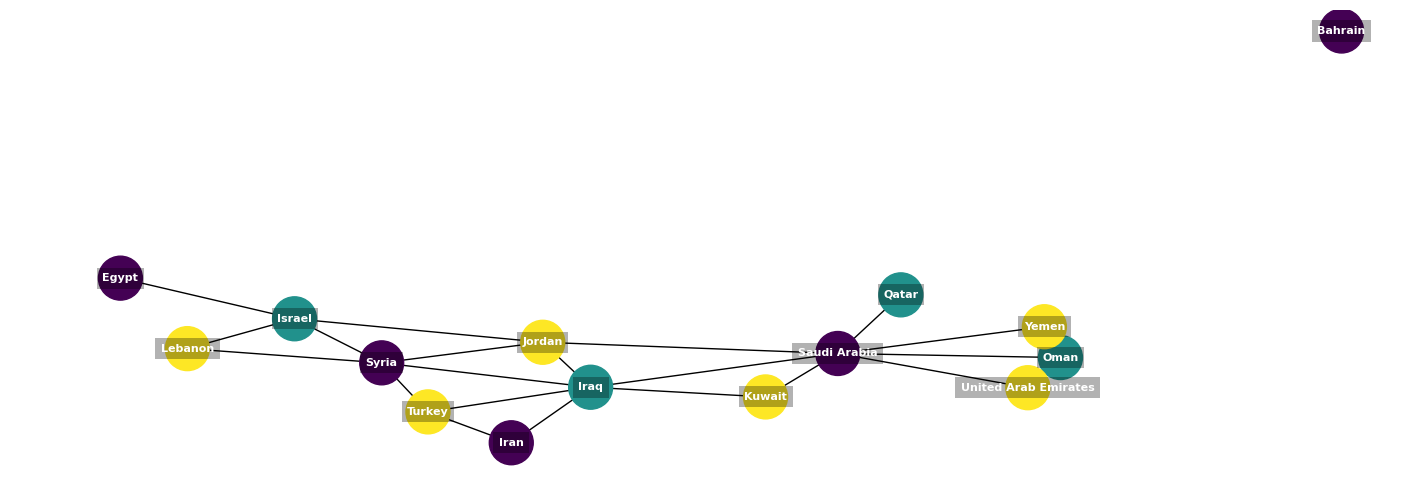

In [7]:

import matplotlib.pyplot as plt

# Apply the greedy coloring algorithm
coloring = nx.coloring.greedy_color(adjacency_graph, strategy='largest_first')

# Prepare colors for visualization
color_map = []
for node in adjacency_graph.nodes():
    color_map.append(coloring[node])

# Create a figure and axis
fig, ax = plt.subplots(figsize=(18, 6))

# Draw the graph on the axis
nx.draw(
    adjacency_graph, ax=ax, with_labels=True, node_size=1000, node_color=color_map, font_size=8,
    font_weight="bold", font_color='white', bbox=dict(facecolor='black', edgecolor='none', alpha=0.3),
)

# Show the plot
plt.show()

# Get the node colors from the matplotlib axes
node_labels = [text.get_text() for text in ax.texts]
node_colors = None
for patch in ax.collections:
    facecolor_array = patch.get_facecolor()
    if facecolor_array.shape[0] == len(node_labels):
        node_colors = [tuple(rgba[:-1]) for rgba in facecolor_array]
        # node_colors = ["#{:02x}{:02x}{:02x}".format(int(rgba[0] * 255), int(rgba[1] * 255), int(rgba[2] * 255)) for rgba in facecolor_array]
        break

if node_colors:
    node_colors_dict = {node_label: node_color for node_label, node_color in zip(node_labels, node_colors)}
    
    # Sort the nodes by highest degree first
    node_labels_colors = sorted(
        [(node_label, node_color) for node_label, node_color in node_colors_dict.items()], key=lambda x: adjacency_graph.degree(x[0]), reverse=True
    )

In [8]:

# Remove the spread point closest to each node color in turn until you run out of spread points
hex_color_dict = {}
locations_list = [tuple(color) for color in spread_points[1:]]
for country_name, node_color in node_labels_colors:
    nearest_neighbor = nu.get_nearest_neighbor(node_color, locations_list)
    rgb = locations_list.pop(locations_list.index(nearest_neighbor))
    hex_color_dict[country_name] = "#{:02x}{:02x}{:02x}".format(int(rgb[0] * 255), int(rgb[1] * 255), int(rgb[2] * 255))

# Create a separate hex color dictionary for use in the cartogram
hex_color_dict['Ocean'] = '#87ceeb'
hex_color_dict

{'Saudi Arabia': '#6b1400', 'Iraq': '#00a2ab', 'Syria': '#800000', 'Israel': '#00338f', 'Jordan': '#ffb900', 'Oman': '#009fff', 'Turkey': '#ffb400', 'Iran': '#003200', 'Kuwait': '#be931e', 'Lebanon': '#ffd4e8', 'United Arab Emirates': '#d50000', 'Yemen': '#c10010', 'Egypt': '#7f00ca', 'Qatar': '#006500', 'Bahrain': '#00ffff', 'Ocean': '#87ceeb'}


## Combine some Wikipedia with Natural Earth data

In [9]:

# Retrieve tables from Wikipedia as a list of data frames
tables_url = 'https://en.wikipedia.org/wiki/'
tables_url += 'List_of_Middle_Eastern_countries_by_population'
page_tables_list = nu.get_page_tables(tables_url, verbose=True)

[(0, (16, 10)), (1, (13, 2))]


In [10]:

# Clean up the Wikipedia table data create a population dictionary
populations_df = page_tables_list[0].copy()
populations_df.columns = [
    'population_rank', 'country_name', 'projection_2020', 'population_percentage', 'annual_growth_percent', 'annual_growth_absolute',
    'doubling_time_years', 'official_population', 'last_figure_date', 'figure_source'
]
populations_df = populations_df.iloc[:-1]
populations_dict = populations_df.set_index('country_name').official_population.to_dict()

In [11]:

# Add the population column to the natural earth data frame
countries_df['official_population'] = countries_df.NAME_EN.map(lambda x: populations_dict.get(x))

In [12]:

# Get a tupled list of (convex) country boundary areas
mask_series = countries_df.NAME_EN.isin(country_names)
country_areas = []
for (country_name, geometry, official_population), df in countries_df[mask_series].groupby(['NAME_EN', 'geometry', 'official_population']):
    bounds_tuple = geometry.bounds
        
    # Bounds Breakdown:
    minx = bounds_tuple[0]
    miny = bounds_tuple[1]
    maxx = bounds_tuple[2]
    maxy = bounds_tuple[3]
    
    # Rectangle Parameters:
    width = maxx - minx
    height = maxy - miny

    # Boundary area creation
    country_area = width * height
    
    area_tuple = (country_name, country_area, official_population)
    country_areas.append(area_tuple)
country_areas = sorted(country_areas, key=lambda x: x[1], reverse=True)
country_areas

[('Saudi Arabia', 331.7788232081368, 34719418.0), ('Iran', 284.01399394254867, 79356000.0), ('Turkey', 120.20356206680844, 83614362.0), ('Egypt', 117.98247035326742, 98202000.0), ('Yemen', 82.57279020407178, 29719300.0), ('Iraq', 81.33432328579566, 40575000.0), ('Oman', 76.64253424717411, 4941100.0), ('Syria', 33.34787577668872, 21377000.0), ('Jordan', 18.1596585328054, 10248069.0), ('United Arab Emirates', 16.627817659608485, 9154000.0), ('Israel', 6.422839435348814, 9100000.0), ('Kuwait', 2.9734908882563205, 4259500.0), ('Lebanon', 2.455264542634866, 6830600.0), ('Qatar', 1.3850950067221495, 2412483.0), ('Bahrain', 0.31085804838628295, 1701000.0)]


## First cartogram attempt

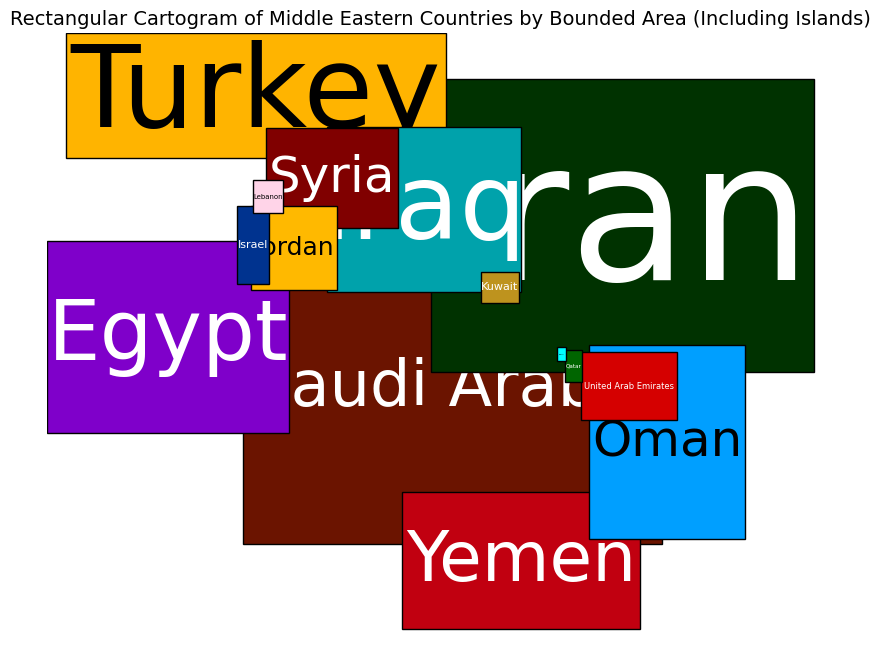

In [13]:

# Create a rectangular cartogram of middle eastern countries by bounded area (including islands)
import matplotlib.patches as patches
import webcolors

# Create the cartogram
fig, ax = plt.subplots(figsize=(12, 8))

# Initialize a base zorder for rectangles
base_zorder = 1

# Loop through countries and their properties
for (country_name, country_area, official_population) in country_areas:
    mask_series = countries_df.NAME_EN.isin([country_name])
    for (country_name, geometry), df in countries_df[mask_series].groupby(['NAME_EN', 'geometry']):
        bounds_tuple = geometry.bounds
            
        # Bounds Breakdown:
        minx = bounds_tuple[0]
        miny = bounds_tuple[1]
        maxx = bounds_tuple[2]
        maxy = bounds_tuple[3]
        
        # Rectangle Parameters:
        lower_left_corner = (minx, miny)
        width = maxx - minx
        height = maxy - miny
        
        # Add rectangle with current zorder
        facecolor = hex_color_dict[country_name]
        rect = patches.Rectangle(
            lower_left_corner, width, height,
            edgecolor="black",
            facecolor=facecolor,
            zorder=base_zorder,  # Current zorder for rectangle
        )
        ax.add_patch(rect)
    
        # Add country name with higher zorder than the rectangle
        rgb_tuple = tuple(webcolors.hex_to_rgb(facecolor))
        ax.text(
            minx + width / 2, miny + height / 2, country_name,
            alpha=1.0,
            color=nu.get_text_color(
                bar_color_rgb=rgb_tuple,
                readable_colors=['black', '#080808', 'white']
            ),
            fontsize=fontsize_dict[country_name],
            ha="center",
            va="center",
            zorder=base_zorder + 1,  # Higher than the current rectangle
        )

        # Increment base zorder for the next rectangle
        base_zorder += 1

# Adjust plot limits
mask_series = countries_df.NAME_EN.isin(country_names)
xlim_minx = countries_df[mask_series].geometry.map(lambda g: g.bounds[0]).min()
xlim_maxx = countries_df[mask_series].geometry.map(lambda g: g.bounds[2]).max()
ax.set_xlim(xlim_minx, xlim_maxx+1)
ylim_miny = countries_df[mask_series].geometry.map(lambda g: g.bounds[1]).min()
ylim_maxy = countries_df[mask_series].geometry.map(lambda g: g.bounds[3]).max()
ax.set_ylim(ylim_miny-1, ylim_maxy)
ax.set_aspect("equal")
plt.title("Rectangular Cartogram of Middle Eastern Countries by Bounded Area (Including Islands)", fontsize=14)
plt.axis("off")
plt.show()


## Second cartogram attempt

In [14]:

# Merge the country grid data frame with the polygon grid data frame
xy_unit_country_name_polygons_df = nu.load_object('xy_unit_country_name_polygons_df')

In [15]:

import matplotlib.pyplot as plt

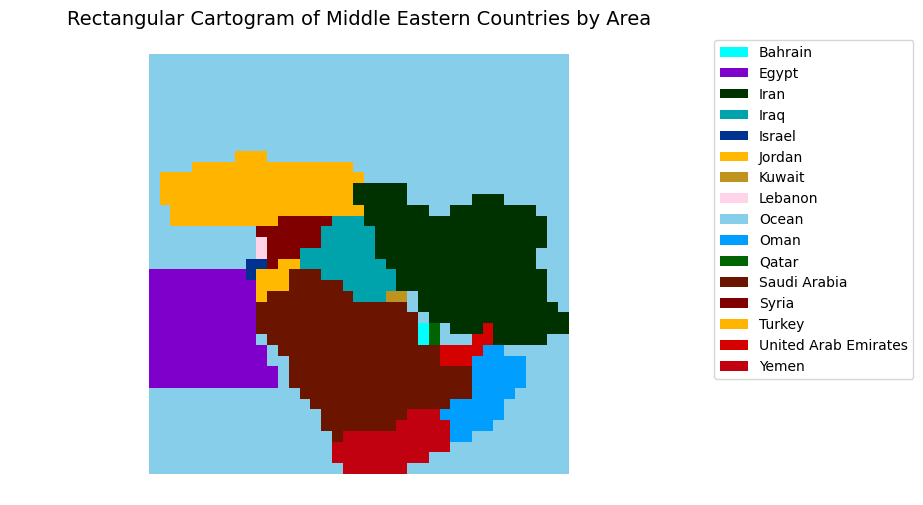

In [16]:

from shapely.geometry.polygon import Polygon

# Create a rectangular cartogram of middle eastern countries by area using our spaced colors
fig, ax = plt.subplots(figsize=(9, 6))
alpha = 1.0

# Set to keep track of added labels
added_labels = set()

for row_index, row_series in xy_unit_country_name_polygons_df.iterrows():
    country_name = row_series.country_name
    polygon = row_series.polygon
    assert isinstance(polygon, Polygon)
    xs, ys = polygon.exterior.xy
    
    # Only add the label if it hasn't been added yet
    if country_name not in added_labels:
        ax.fill(xs, ys, alpha=alpha, fc=hex_color_dict[country_name], ec='none', label=country_name)
        added_labels.add(country_name)
    else:
        ax.fill(xs, ys, alpha=alpha, fc=hex_color_dict[country_name], ec='none')

# Get the handles and labels from the plot
handles, labels = ax.get_legend_handles_labels()

# Sort the labels and handles alphabetically
sorted_handles_labels = sorted(zip(labels, handles), key=lambda x: x[0])  # Sort by label (alphabetical order)
sorted_labels, sorted_handles = zip(*sorted_handles_labels)  # Unzip into two separate lists

# Create the legend with sorted labels
plt.legend(sorted_handles, sorted_labels, bbox_to_anchor=(1.0, 1.0))

ax.set_aspect('equal', 'datalim')
plt.title("Rectangular Cartogram of Middle Eastern Countries by Area", fontsize=14)
plt.axis("off")
plt.show()


## Try to vary the size of the countries while managing centroids and borders


Cartogram
---------

A cartogram distorts (grows or shrinks) polygons on a map according to the magnitude of some
input data. A basic cartogram specifies data, a projection, and a ``scale`` parameter.

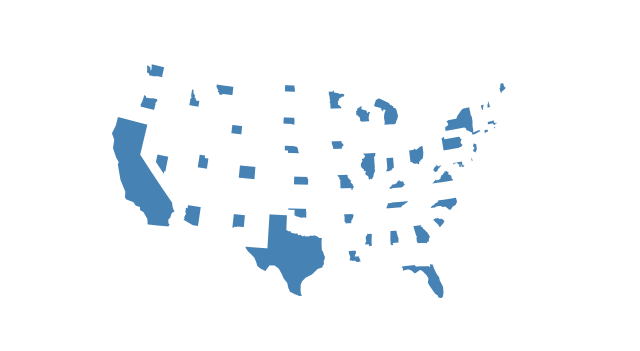

In [25]:

import geoplot as gplt
import geoplot.crs as gcrs
import geopandas as gpd

contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa'))

# fig, ax = plt.subplots(figsize=(9, 6))
gplt.cartogram(contiguous_usa, scale='population', projection=gcrs.AlbersEqualArea())
plt.show()


Toggle the legend with ``legend``. Keyword arguments can be passed to the legend using the
``legend_kwargs`` argument. These arguments will be passed to the underlying legend.

In [ ]:

gplt.cartogram(
    contiguous_usa, scale='population', projection=gcrs.AlbersEqualArea(),
    legend=True, legend_kwargs={'loc': 'lower right'}
)


To add a colormap to the plot, specify ``hue``. Use ``cmap`` to control the colormap. For a
categorical colormap, specify a ``scheme``. In this plot we also add a backing outline of the
original state shapes, for better geospatial context.

In [ ]:

import mapclassify as mc

scheme = mc.Quantiles(contiguous_usa['population'], k=5)
ax = gplt.cartogram(
    contiguous_usa, scale='population', projection=gcrs.AlbersEqualArea(),
    legend=True, legend_kwargs={'bbox_to_anchor': (1, 0.9)}, legend_var='hue',
    hue='population', scheme=scheme, cmap='Greens'
)
gplt.polyplot(contiguous_usa, facecolor='lightgray', edgecolor='white', ax=ax)


Use ``legend_labels`` and ``legend_values`` to customize the labels and values that appear
in the legend.

In [ ]:

gplt.cartogram(
    contiguous_usa, scale='population', projection=gcrs.AlbersEqualArea(),
    legend=True, legend_kwargs={'bbox_to_anchor': (1, 0.9)}, legend_var='hue',
    hue='population', scheme=scheme, cmap='Greens',
    legend_labels=[
        '<1.4 million', '1.4-3.2 million', '3.2-5.6 million',
        '5.6-9 million', '9-37 million'
    ]
)
gplt.polyplot(contiguous_usa, facecolor='lightgray', edgecolor='white', ax=ax)


Use the ``limits`` parameter to adjust the minimum and maximum scaling factors.
You can also pass a custom scaling function to ``scale_func`` to apply a
different scale to the plot (the default scaling function is linear); see the
:doc:`/gallery/plot_usa_city_elevations` for an example.

In [ ]:

ax = gplt.cartogram(
    contiguous_usa, scale='population', projection=gcrs.AlbersEqualArea(),
    legend=True, legend_kwargs={'bbox_to_anchor': (1, 0.9)}, legend_var='hue',
    hue='population', scheme=scheme, cmap='Greens',
    legend_labels=[
        '<1.4 million', '1.4-3.2 million', '3.2-5.6 million',
        '5.6-9 million', '9-37 million'
    ],
    limits=(0.5, 1)
)
gplt.polyplot(contiguous_usa, facecolor='lightgray', edgecolor='white', ax=ax)

In [19]:

# Create a dictionary of the union of all polygons for a country on the grid
union_polygons_dict = {}
for country_name, country_name_df in xy_unit_country_name_polygons_df.groupby('country_name'):
    union_polygon = Polygon()
    for polygon in country_name_df.polygon:
        union_polygon = union_polygon.union(polygon)
    union_polygons_dict[country_name] = union_polygon

In [20]:

# Get the population data for years 2022 - 2024
interpolated_years_df = nu.load_object('interpolated_years_df')
interpolated_years_df / interpolated_years_df.loc[2024]

,Bahrain,Egypt,Iran,Iraq,Israel,Jordan,Kuwait,Lebanon,Oman,Qatar,Saudi Arabia,Syria,Turkey,United Arab Emirates,Yemen
year,,,,,,,,,,,,,,,
1922,0.050112,0.112393,0.111376,0.065091,0.076283,0.019236,0.007124,0.132991,0.057779,1.114913,0.028014,0.068159,0.131562,0.016322,0.043075
1923,0.049898,0.115962,0.112635,0.066825,0.076330,0.019282,0.007153,0.132693,0.057816,1.050602,0.029828,0.083872,0.136981,0.016329,0.047558
1924,0.049770,0.119345,0.114046,0.068632,0.076476,0.019420,0.007240,0.132781,0.057927,0.988768,0.031686,0.098328,0.142493,0.016351,0.051934
1925,0.049727,0.122551,0.115604,0.070512,0.076728,0.019647,0.007385,0.133243,0.058108,0.929368,0.033587,0.111581,0.148095,0.016388,0.056207
1926,0.049770,0.125587,0.117305,0.072463,0.077092,0.019961,0.007589,0.134066,0.058359,0.872354,0.035530,0.123681,0.153787,0.016441,0.060379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020,0.926690,0.942269,0.972202,0.935048,0.928369,0.923834,0.908666,0.958910,0.865918,0.904829,1.091182,0.943916,0.981045,0.841710,0.927091
2021,0.946934,0.955916,0.979253,0.953302,0.947007,0.945293,0.882510,0.947057,0.874885,0.877372,1.089757,0.968953,0.993552,0.894176,0.947135
2022,0.959729,0.970377,0.986236,0.970262,0.973342,0.966238,0.892627,0.945652,0.953419,0.936119,1.079784,0.987786,1.000583,0.932980,0.966029


In [21]:

interpolated_years_df / interpolated_years_df.loc[1924]

,Bahrain,Egypt,Iran,Iraq,Israel,Jordan,Kuwait,Lebanon,Oman,Qatar,Saudi Arabia,Syria,Turkey,United Arab Emirates,Yemen
year,,,,,,,,,,,,,,,
1922,1.006868,0.941749,0.976592,0.948409,0.997476,0.990496,0.983920,1.001580,0.997448,1.127577,0.884111,0.693181,0.923288,0.998253,0.829415
1923,1.002580,0.971651,0.987627,0.973663,0.998091,0.992890,0.987940,0.999334,0.998092,1.062536,0.941370,0.852979,0.961322,0.998680,0.915725
1924,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1925,0.999140,1.026861,1.013665,1.027392,1.003293,1.011683,1.020072,1.003479,1.003136,0.939925,1.059987,1.134777,1.039316,1.002268,1.082279
1926,1.000000,1.052300,1.028578,1.055811,1.008065,1.027818,1.048184,1.009677,1.007469,0.882263,1.121316,1.257841,1.079264,1.005535,1.162600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020,18.619467,7.895313,8.524668,13.624061,12.139408,47.570204,125.506606,7.221713,14.948516,0.915107,34.437498,9.599637,6.884886,51.478856,17.851228
2021,19.026218,8.009657,8.586486,13.890039,12.383118,48.675157,121.893962,7.132446,15.103318,0.887338,34.392534,9.854266,6.972654,54.687669,18.237183
2022,19.283313,8.130828,8.647719,14.137149,12.727474,49.753697,123.291268,7.121865,16.459060,0.946752,34.077787,10.045795,7.021999,57.060954,18.600987


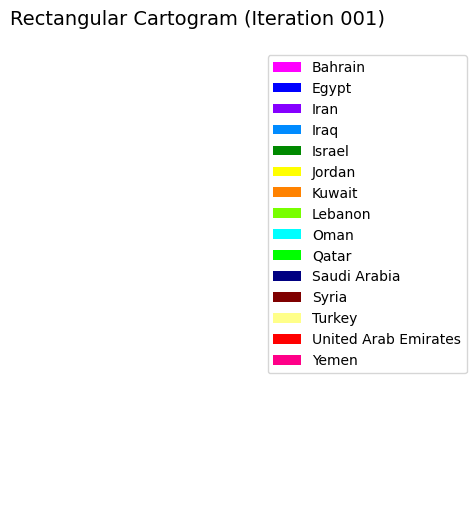

In [22]:

from shapely.geometry.point import Point
from shapely.affinity import scale

# Get the proportions countries have grown since 1924
df = interpolated_years_df / interpolated_years_df.loc[1924]

# Create a list to store scaled polygons and their original centroids
scaled_polygons = []

# Prepare the polygons with their original centroids and neighbors
for country_name in df.columns:
    union_polygon = union_polygons_dict[country_name]
    assert isinstance(union_polygon, Polygon)
    
    # Scale factors
    x_scale = y_scale = df.loc[1927, country_name]
    
    # Apply scaling
    scaled_polygon = scale(union_polygon, xfact=x_scale, yfact=y_scale, origin=union_polygon.centroid)
    
    # Store the scaled polygon and its original centroid
    poly_data = {
        'country_name': country_name,
        'polygon': scaled_polygon,
        'original_centroid': scaled_polygon.centroid.coords[0],
        'neighbors': {
            neighbor: union_polygon.intersection(union_polygons_dict[neighbor])
            for neighbor in adjacency_graph.neighbors(country_name)
        }
    }
    scaled_polygons.append(poly_data)

# Adjust all polygons to minimize overlap while being attracted to their original neighbors
adjusted_polygons = nu.adjust_polygons(scaled_polygons, hex_color_dict, verbose=True)

# Create a rectangular cartogram of middle eastern countries by scaled population
nu.plot_adjusted_polygons(adjusted_polygons, 1, hex_color_dict)

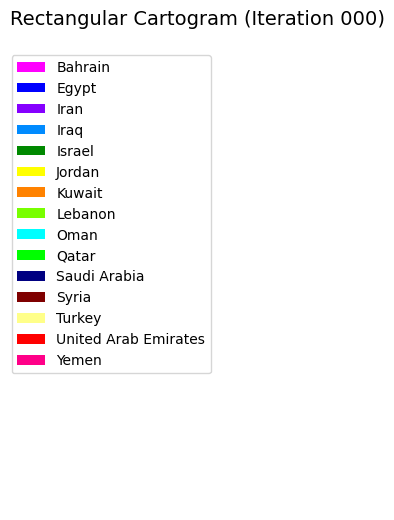

In [24]:

from shapely.geometry.point import Point
from shapely.affinity import translate

# Get the proportions countries have grown since 1924
df = interpolated_years_df / interpolated_years_df.loc[1924]

# Create a list to store translated polygons and their original centroids
translated_polygons = []

# Prepare the polygons with their original centroids and neighbors
for country_name in df.columns:
    union_polygon = union_polygons_dict[country_name]
    assert isinstance(union_polygon, Polygon)
    
    # Apply move to Iran
    if country_name != 'Iran':
        translated_polygon = translate(union_polygon, xoff=100, yoff=100)
    else:
        translated_polygon = translate(union_polygon, xoff=0, yoff=0)
    
    # Store the translated polygon and its original centroid
    poly_data = {
        'country_name': country_name,
        'polygon': translated_polygon,
        'original_centroid': translated_polygon.centroid.coords[0],
        'neighbors': {
            neighbor: union_polygon.intersection(union_polygons_dict[neighbor])
            for neighbor in adjacency_graph.neighbors(country_name)
        }
    }
    translated_polygons.append(poly_data)

# Adjust all polygons to minimize overlap while being attracted to their original neighbors
adjusted_polygons = nu.adjust_polygons(
    translated_polygons, hex_color_dict, attraction_factor=0.5, repulsion_factor=0.5, verbose=True
)

# Create a rectangular cartogram of middle eastern countries by translated population
nu.plot_adjusted_polygons(adjusted_polygons, 0, hex_color_dict)

In [25]:

import glob
import imageio.v2 as imageio
import numpy as np
from PIL import Image

# Get a sorted list of all PNG paths in the folder
image_paths = sorted([osp.abspath(f) for f in glob.glob("../saves/movies/*.png", recursive=True)])
if image_paths:
    
    # Read each PNG path and append it to the images list
    images = []

    # Determine the target size (based on the first image)
    first_image = Image.open(image_paths[0])
    target_size = first_image.size  # (width, height)

    for file_path in image_paths:
        try:
            
            # Open the image
            img = Image.open(file_path)

            # Resize the image to match the target size
            img_resized = img.resize(target_size, Image.Resampling.LANCZOS)

            # Convert to numpy array and append to the list
            images.append(np.array(img_resized))
    
        except Exception as e:
            print(f"Error processing file {file_path}: {e}")

    # Create the animated GIF
    imageio.mimsave("../saves/movies/animated_cartogram.gif", images, duration=1)